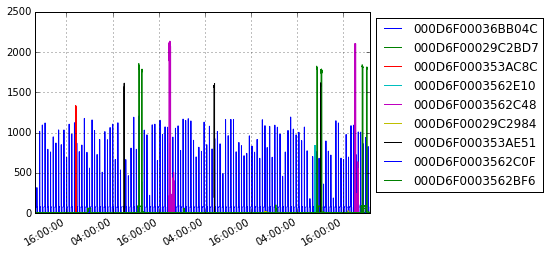

In [1]:
%matplotlib inline
from load_disaggregator import *

# building 1    
devices = ['000D6F00036BB04C', '000D6F00029C2BD7', '000D6F000353AC8C', '000D6F0003562E10', '000D6F0003562C48', '000D6F00029C2984', '000D6F000353AE51', '000D6F0003562C0F', '000D6F0003562BF6']

dataset_folder = "/Users/andreamonacchi/Downloads/GREEND_0-2_300615/"
template_folder = "/Users/andreamonacchi/Desktop/"
        
processor = DatasetProcessor(dataset_folder)        
df = processor.get_dataframe(1, 4)

ax = df.plot(legend=False)
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

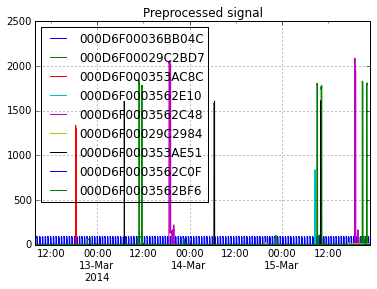

In [2]:
# preprocess the dataset
preprocessed = processor.remove_holes()             # fill with our method (pad and bfill)
preprocessed = processor.uniform_period()           # makes sure the signal is at 1Hz
preprocessed = processor.remove_noise(sizes=[30]*9) # median filter over 30 consecutive samples
preprocessed = processor.downsample('10S')          # downsample to 1/10 Hz (should make device signature even more similar by removing spikes)
preprocessed.plot(title="Preprocessed signal")

In [3]:
# get the datastore (from disk)
processor.get_datastore(template_folder+"dev_signatures.h5")

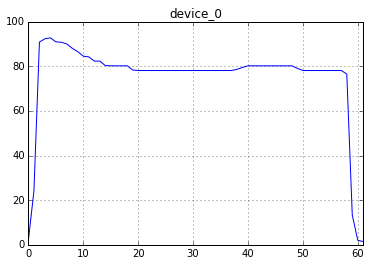

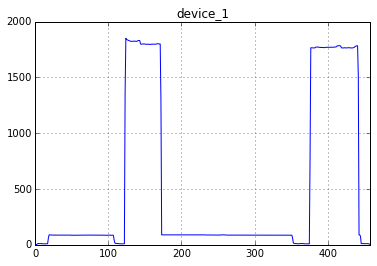

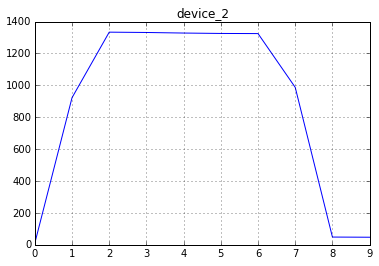

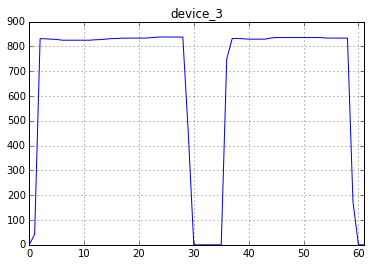

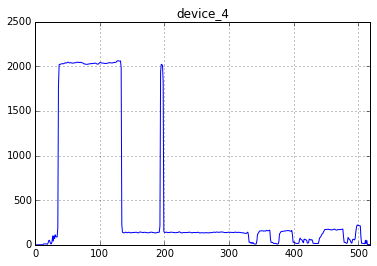

In [5]:
# switch between signature extraction and load disaggregation
extract = False

if extract:    
    # Extract signatures for individual devices
    #disagg = processor.get_disaggregated_signal(devices[1])
    #disagg.plot()
    
    # Device 0 (fridge)
    ##signature = processor.select_time_interval('08:18:40', '08:28:40')[devices[0]]
    signature0 = processor.select_datetime_interval('2014-03-12 08:18:40', '2014-03-12 08:29:00')[devices[0]]
    processor.add_signature('devices/d0', signature0)
    
    #Device 1 (dishwasher)
    signature1 = processor.select_datetime_interval('2014-03-13 10:28:30',  '2014-03-13 11:45:00')[devices[1]]
    processor.add_signature('devices/d1', signature1)
    
    # Device 2 (microwave)
    ##signature = processor.select_time_interval('18:24:40', '18:26:20')[devices[2]]
    signature2 = processor.select_datetime_interval('2014-03-12 18:24:40',  '2014-03-12 18:26:20')[devices[2]]
    processor.add_signature('devices/d2', signature2)

    # Device 3 water kettle
    signature3 = processor.select_datetime_interval('2014-03-15 08:32:00', '2014-03-15 08:42:20')[devices[3]]    
    processor.add_signature('devices/d3', signature3)

    # Device 4
    signature4 = processor.select_datetime_interval('2014-03-13 18:32:00', '2014-03-13 19:58:30')[devices[4]]    # on the second day (that is why we use datetime)
    processor.add_signature('devices/d4', signature4)

    # Device 5 (amplifier)
    #signature = processor.select_time_interval('18:24:40', '18:26:20')[devices[5]]
    #signature5 = processor.select_datetime_interval('2014-03-12 18:24:40', '2014-03-12 18:26:20')[devices[5]]
    #processor.add_signature('devices/d5', signature5)

    # Device 6 (hair dryer + charger )
    signature6 = processor.select_datetime_interval('2014-03-15 10:03:45', '2014-03-15 10:06:30')[devices[6]]
    processor.add_signature('devices/d6', signature6)

    # Device 7 (food processor) --> neverused
    #signature = processor.select_datetime_interval('', '')[devices[7]]
    
    # Device 8 Bedside lamp
    signature8 = processor.select_datetime_interval('2014-03-13 22:27:45', '2014-03-13 22:37:40')[devices[8]]
    processor.add_signature('devices/d8', signature8)

    #plt.figure()
    #signature.plot(legend=False)
    
else:
    # select a template and attempt the disaggregation
    templates = [processor.get_signature('devices/d0'), processor.get_signature('devices/d1'), processor.get_signature('devices/d2'), processor.get_signature('devices/d3'), processor.get_signature('devices/d4'), None, 
                 None, #processor.get_signature('devices/d6'),
                 None, None] # processor.get_signature('devices/d8') ]

    for i, t in enumerate(templates):
        if t is not None and (not t.empty):
            #print( t )
            plt.figure()
            t.plot(title="device_"+str(i))

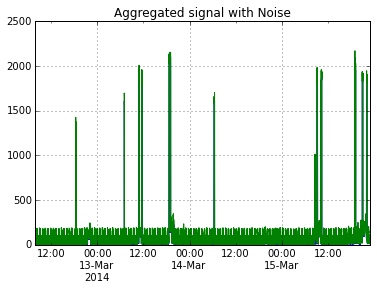

In [21]:
agg = processor.get_aggregated_signal()
agg.plot(title="Ideal aggregated signal")

max_noise = 100.0 # W max power noise
agg = agg + max_noise * np.random.random_sample(len(agg))
agg.plot(title="Aggregated signal with Noise")

In [22]:
min(agg) > 0.0

True

0.999262436704
0.998494199581
0.998315690154
0.989881616838
Device 0 detected 0 times
Device 1 detected 1 times
Device 2 detected 1 times
Device 3 detected 1 times
Device 4 detected 1 times
Device 5 detected 0 times
Device 6 detected 0 times
Device 7 detected 0 times
Device 8 detected 0 times


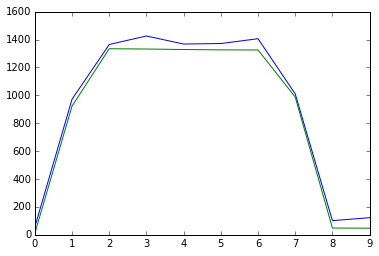

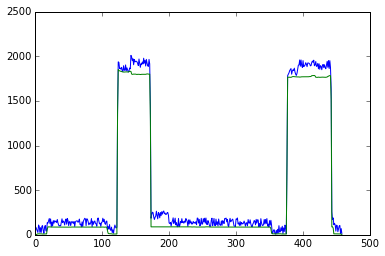

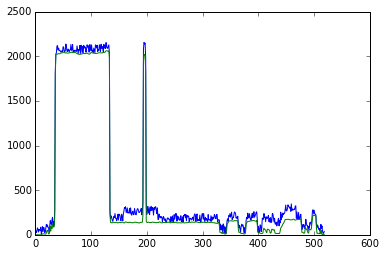

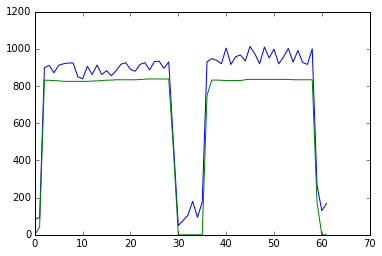

In [23]:
disaggregator = BatchLoadDisaggregator( templates )
    
"""
d_id = 4
counts = disaggregator.disaggregate_dataframe(agg, device_id=d_id, min_corr=0.9)
print "Device "+str(d_id)+" detected "+str(counts[d_id])+" times"
print "MAX CORR: ", disaggregator.get_max_corr()
"""

counts = disaggregator.disaggregate_dataframe(agg, device_id=-1, min_corr=0.989, step_size=1)
for i, c in enumerate(counts):
    print( "Device "+str(i)+" detected "+str(c)+" times" )

In [4]:
# good practice to close the datastore
processor.close_datastore()